In [1]:
# k-meansと凝集型クラスタリングでは、クラスタの数を指定することができる
# DBSCANでは、epsパラメータを用いて近接度を指定すると、間接的にクラスタサイズを制御することができる
# k-meansではクラスタセンタを用いてクラスタの特徴を表すことができる
# k-meansは、個々のデータポイントがクラスタセンタによって表現される成分分解手法として考えることもできる
# DBSCANは、どのクラスタにも属さない「ノイズ」の検出、自動的なクラスタ数の決定、複雑な形状のクラスタの検出、という特徴がある
# DBSCANは、非常に異なるサイズのクラスタを作る場合がある
# 凝集型クラスタリングはデータの階層的な分割の候補をすべて提示する

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

In [3]:
# 顔画像データセットの準備。それぞれの人物が最大50人になるように、かつ0~1の白黒となるように
from sklearn.datasets import fetch_lfw_people

people = fetch_lfw_people(min_faces_per_person = 20, resize = 0.7)
image_shape = people.images[0].shape

mask = np.zeros(people.target.shape, dtype = np.bool_)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

X_people = X_people/255

In [4]:
# PCA(whiten = True)なので、主成分抽出後にStandardScalerをかけてるのと同じ
from sklearn.decomposition import PCA

pca = PCA(n_components = 100, whiten = True, random_state = 0)
pca.fit(X_people)
X_pca = pca.transform(X_people)

<h4>顔画像データセットのDBSCANによる解析</h4>

Unique labels: [-1]
Unique labels: [-1]
Unique labels: [-1  0]
Number of points per cluster: [  32 2031]


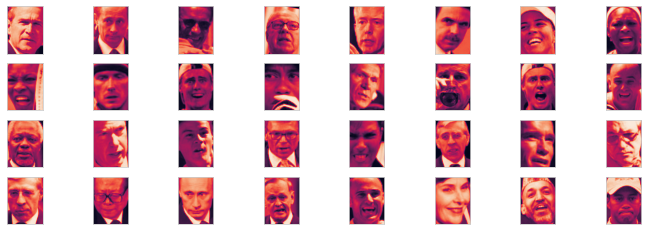

In [5]:
from sklearn.cluster import DBSCAN

# すべてノイズ
dbscan = DBSCAN()
labels = dbscan.fit_predict(X_pca)
print(f"Unique labels: {np.unique(labels)}")

# まだすべてノイズ
dbscan = DBSCAN(min_samples = 3)
labels = dbscan.fit_predict(X_pca)
print(f"Unique labels: {np.unique(labels)}")

# やっと1つのクラスタとノイズ
dbscan = DBSCAN(min_samples = 3, eps = 15)
labels = dbscan.fit_predict(X_pca)
print(f"Unique labels: {np.unique(labels)}")

# データの数を数える
# bincountは0を許さないので1を加える
print(f"Number of points per cluster: {np.bincount(labels + 1)}")

# ノイズに割り当てられている顔画像はどのようなものか
# 帽子被っていたり、グラスで飲み物飲んでたり、手が写りこんでいたり
noise = X_people[labels == -1]
fig, axes = plt.subplots(4, 8, subplot_kw = {"xticks":(),"yticks":()}, figsize = (12, 4))
for image, ax in zip(noise, axes.ravel()):
    ax.imshow(image.reshape(image_shape), vmin= 0, vmax = 1)

In [6]:
# epsを色々と変えてみる
# 興味深い点としては、大きいクラスタが1つ以上得られることはないこと。これはすべての顔画像が同じように似ている（又は似ていない）ということだ
# eps=7が面白そう
for eps in [1,3,5,7,9,11,13]:
    print(f"\neps = {eps}")
    dbscan = DBSCAN(eps = eps, min_samples = 3)
    labels = dbscan.fit_predict(X_pca)
    print(f"Clusters present: {np.unique(labels)}")
    print(f"Cluster sizes: {np.bincount(labels + 1)}")


eps = 1
Clusters present: [-1]
Cluster sizes: [2063]

eps = 3
Clusters present: [-1]
Cluster sizes: [2063]

eps = 5
Clusters present: [-1]
Cluster sizes: [2063]

eps = 7
Clusters present: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12]
Cluster sizes: [2004    3   14    7    4    3    3    4    4    3    3    5    3    3]

eps = 9
Clusters present: [-1  0  1  2]
Cluster sizes: [1307  750    3    3]

eps = 11
Clusters present: [-1  0]
Cluster sizes: [ 413 1650]

eps = 13
Clusters present: [-1  0]
Cluster sizes: [ 120 1943]


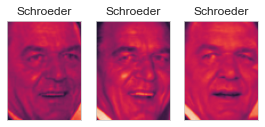

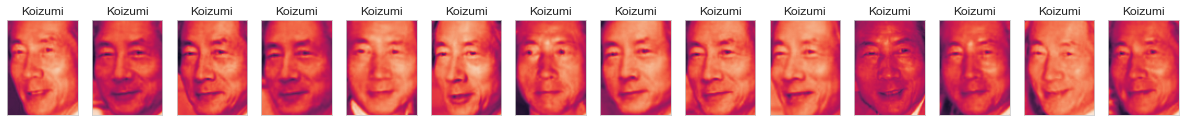

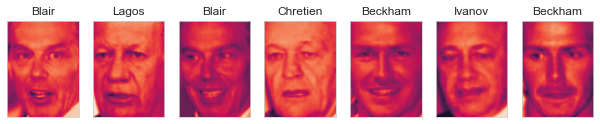

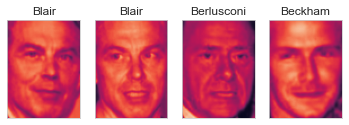

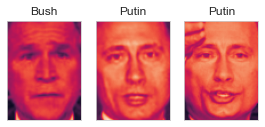

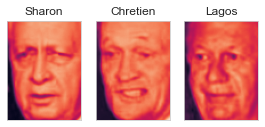

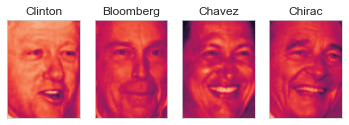

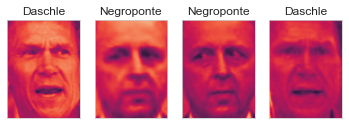

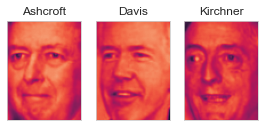

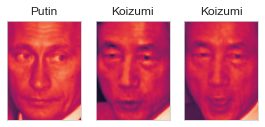

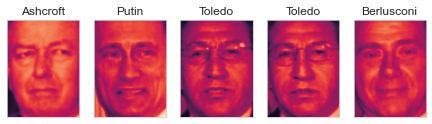

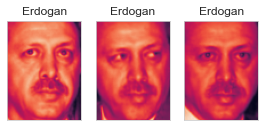

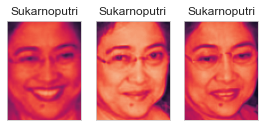

In [7]:
# クラスタのうちいくつかは、データセット中の特定の顔に対応している
# 個々のクラスタ内では、顔の向きや位置、表情が一定している。いくつかのクラスタには複数の人物が含まれているが顔の向きや表情は類似している
dbscan = DBSCAN(eps = 7, min_samples = 3)
labels = dbscan.fit_predict(X_pca)

for cluster in range(max(labels) + 1):
    mask = labels == cluster
    n_images = np.sum(mask)
    fig, axes = plt.subplots(1, n_images, figsize = (n_images * 1.5, 4), subplot_kw = {"xticks":(),"yticks":()})
    
    for image, label, ax in zip(X_people[mask], y_people[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin = 0, vmax = 1)
        ax.set_title(people.target_names[label].split()[-1])

<h4>顔画像データセットのk-meansによる解析</h4>

Cluster sizes k-means: [155 175 238  75 358 257  91 219 323 172]


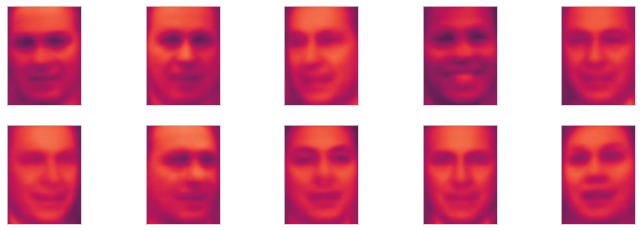

In [8]:
# クラスタ数10は適当
# k-meansクラスタリングでは、75から358と、比較的同じようなサイズのクラスタに分類している。これはDBSCANの結果とは大きく異なる
# pcaで白色化された顔画像クラスターの中心なので、平滑化された顔画像ばかりだ
from sklearn.cluster import KMeans

km = KMeans(n_clusters = 10, random_state = 0)
labels_km = km.fit_predict(X_pca)
print(f"Cluster sizes k-means: {np.bincount(labels_km)}")

fig, axes = plt.subplots(2, 5, subplot_kw = {"xticks":(),"yticks":()}, figsize = (12, 4))
for center, ax in zip(km.cluster_centers_, axes.ravel()):
    ax.imshow(pca.inverse_transform(center).reshape(image_shape), vmin = 0, vmax = 1)

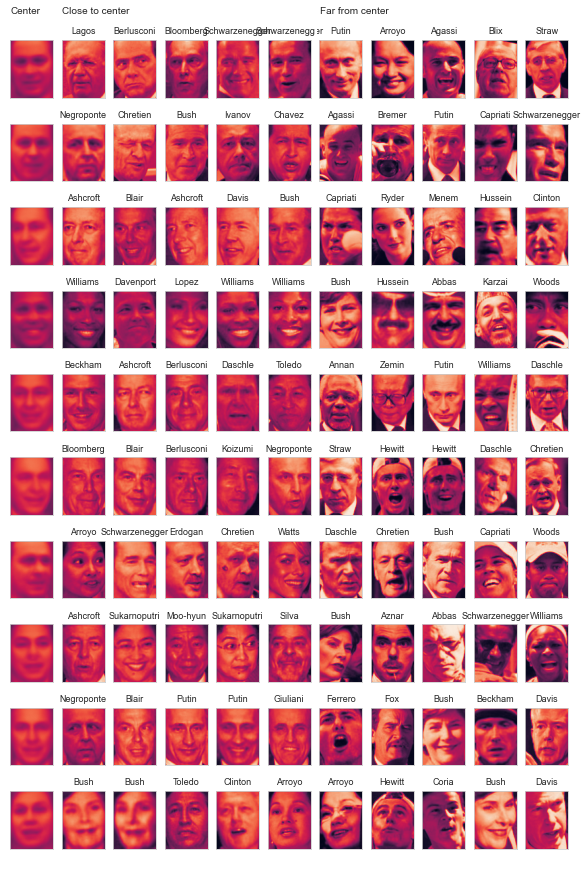

In [9]:
# 左がクラスタセンターの元顔画像、続いて5個がクラスタセンタに最も近い顔画像、最後の5個がクラスタセンタから最も遠い顔画像
# 正直、クラスタセンタから遠い顔画像はクラスタセンタと似ておらず、たまたま分類されているように見える
# これは、k-meansにはノイズの概念がなく、全てのデータポイントがどこからのクラスタに分類されているからだ
import mglearn

mglearn.plots.plot_kmeans_faces(km, pca, X_pca, X_people, y_people, people.target_names)

<h4>凝集型クラスタリングによる顔画像データセットの解析</h4>

In [10]:
# 凝集型クラスタリングによる結果は、最小で18画像、最大で660画像、k-meansと比べると偏りが大きいが、DBSCANと比べるとはるかに均等に分類されている
from sklearn.cluster import AgglomerativeClustering

agglomerative = AgglomerativeClustering(n_clusters = 10)
labels_agg = agglomerative.fit_predict(X_pca)
print(labels_agg)
print(f"Cluster sizes agglomerative clustering: {np.bincount(labels_agg)}")

[9 7 1 ... 0 0 2]
Cluster sizes agglomerative clustering: [169 660 144 329 217  85  18 261  31 149]


In [11]:
# k-meansの結果と凝集型クラスタリングの結果はほとんど共通点がない
from sklearn.metrics.cluster import adjusted_rand_score

print(f"ARI: {adjusted_rand_score(labels_agg, labels_km):.2f}")

ARI: 0.09


Text(0, 0.5, 'Cluster distance')

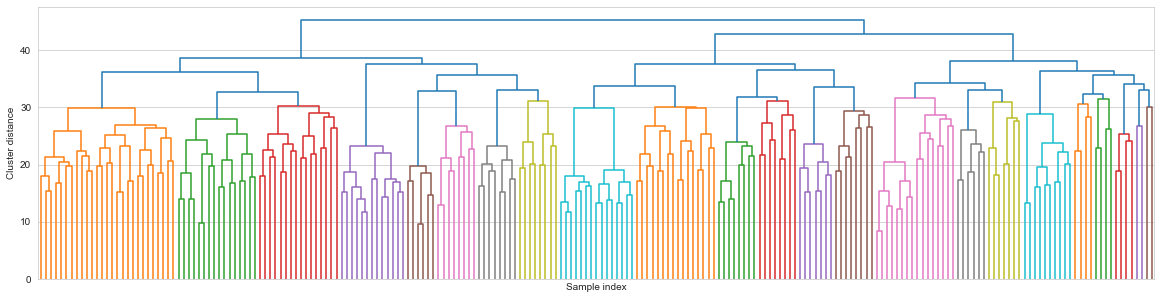

In [12]:
# 正直、どこで切るのが適切なクラスタ数なのか、枝の長さからではわからない
# DBSCANの結果が1つの大きなクラスタを作っていたから、そんなものかもしれない
from scipy.cluster.hierarchy import dendrogram, ward

linkage_array = ward(X_pca)
plt.figure(figsize = (20, 5))
dendrogram(linkage_array, p = 7, truncate_mode = "level", no_labels = True) #表示するデンドログラムの深さを制限（全表示すると恐ろしいことに）
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

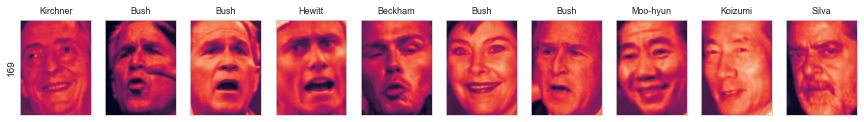

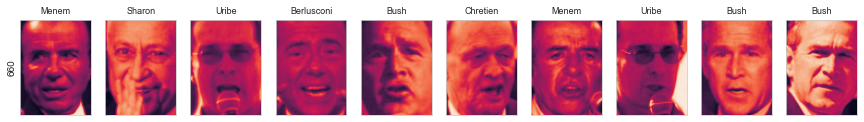

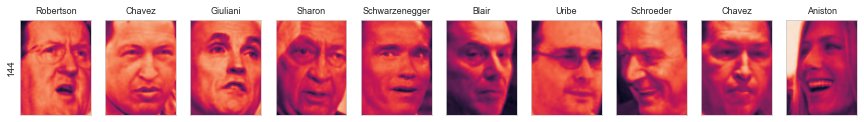

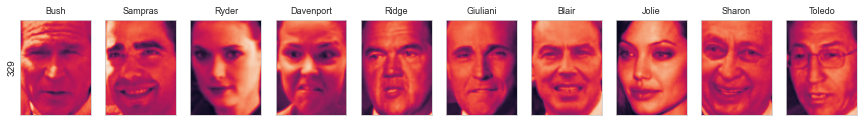

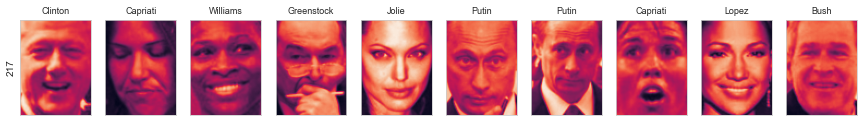

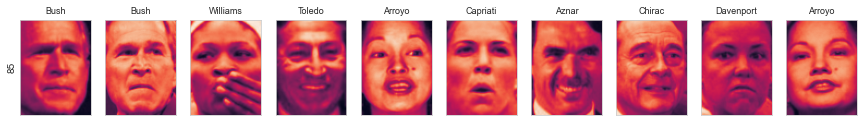

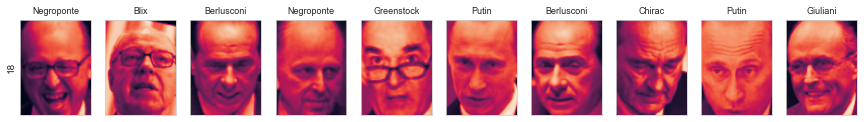

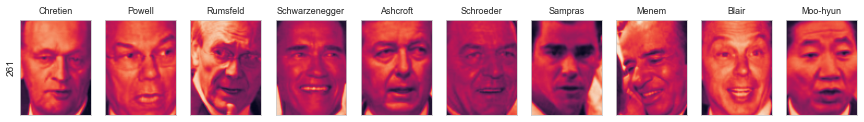

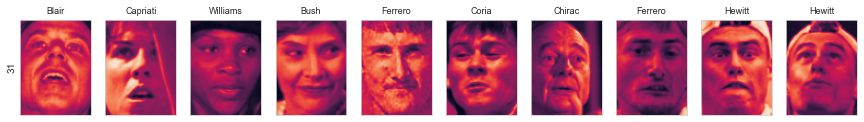

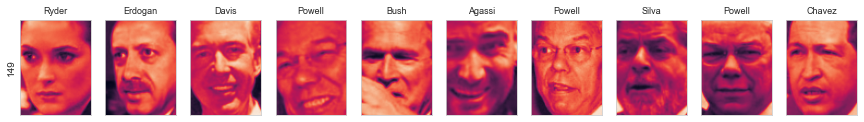

In [13]:
# 10クラスタに分けて、それぞれのクラスタに属する顔画像といくつか表示してみる
# なんか特徴がありそうだけど、クラスタ数が少なすぎるのか、大雑把でよくわからない
n_clusters = 10
for cluster in range(n_clusters):
    mask = labels_agg == cluster
    fig, axes = plt.subplots(1, 10, subplot_kw = {"xticks":(),"yticks":()}, figsize = (15, 8))
    axes[0].set_ylabel(np.sum(mask))
    for image, label, ax in zip(X_people[mask], y_people[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin = 0, vmax = 1)
        ax.set_title(people.target_names[label].split()[-1], fontdict = {"fontsize":9})

cluster sizes agglomerative clustering:
 [ 43 120 100 194  56  58 127  22   6  37  65  49  84  18 168  44  47  31
  78  30 166  20  57  14  11  29  23   5   8  84  67  30  57  16  22  12
  29   2  26   8]


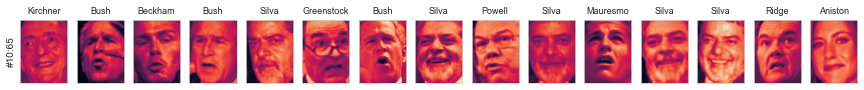

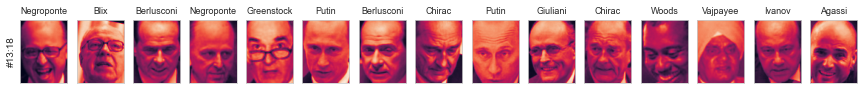

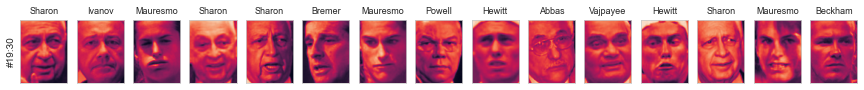

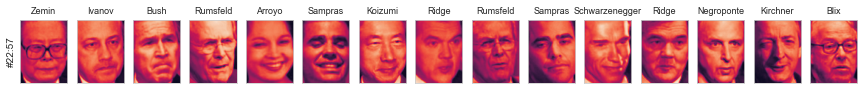

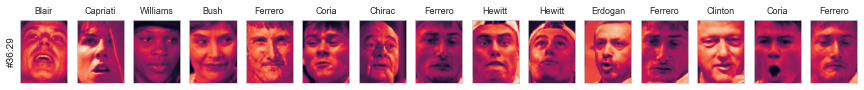

In [14]:
# クラスタ数を40にして上記と同じことを実行
# クラスタ数10よりは、特徴の強く出ている顔画像が多そうだ

agglomerative = AgglomerativeClustering(n_clusters = 40)
labels_agg = agglomerative.fit_predict(X_pca)
print(f"cluster sizes agglomerative clustering:\n {np.bincount(labels_agg)}")

n_clusters = 40
for cluster in [10, 13, 19, 22, 36]: #clusterを抜粋
    mask = labels_agg == cluster
    fig, axes = plt.subplots(1, 15, subplot_kw = {"xticks":(),"yticks":()},figsize = (15, 8))
    cluster_size = np.sum(mask)
    axes[0].set_ylabel(f"#{cluster}:{cluster_size}")
    for image, label, asdf,ax in zip(X_people[mask], y_people[mask], labels_agg[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin = 0, vmax = 1)
        ax.set_title(people.target_names[label].split()[-1], fontdict = {"fontsize":9})
    
    for i in range(cluster_size, 15):
        axes[i].set_visible(False)